In [6]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pickle

In [7]:
df = pd.read_csv("fake_news_dataset.csv")

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["cleaned_text"] = df["Text"].apply(clean_text)

df["char_count"] = df["cleaned_text"].apply(len)
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

vectorizer = CountVectorizer(stop_words="english")
bow_matrix = vectorizer.fit_transform(df["cleaned_text"])

word_counts = bow_matrix.sum(axis=0)
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


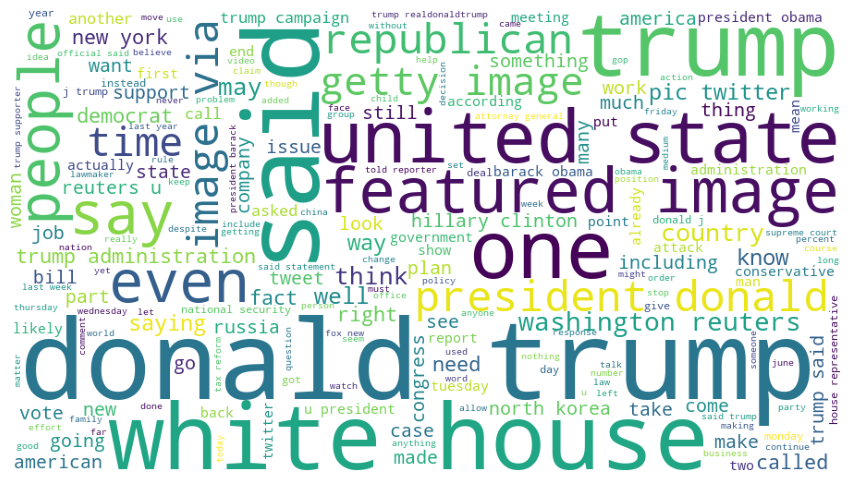

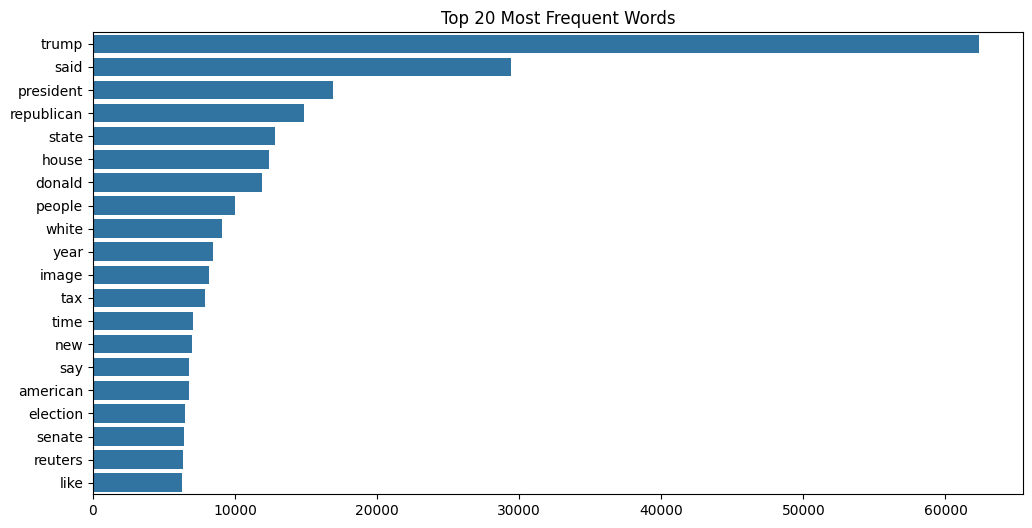

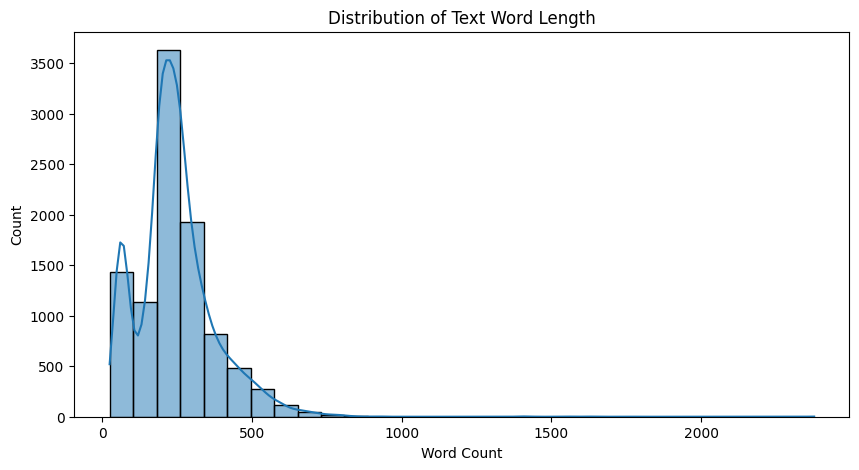

In [8]:

wc = WordCloud(width=900, height=500, background_color="white") \
        .generate(" ".join(df["cleaned_text"]))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

top20 = word_freq_sorted[:20]
words = [w for w, _ in top20]
counts = [c for _, c in top20]

plt.figure(figsize=(12,6))
sns.barplot(x=counts, y=words)
plt.title("Top 20 Most Frequent Words")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Distribution of Text Word Length")
plt.xlabel("Word Count")
plt.show()


In [9]:

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df["cleaned_text"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

lr = LogisticRegression(max_iter=300)
nb = MultinomialNB()
svm = LinearSVC()

models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "SVM": svm
}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("F1:", f1_score(y_test, pred, pos_label="Real"))
    print("Confusion Matrix:\n", confusion_matrix(y_test, pred))


Logistic Regression
Accuracy: 0.9893939393939394
F1: 0.9892583120204603
Confusion Matrix:
 [[992   8]
 [ 13 967]]

Naive Bayes
Accuracy: 0.9595959595959596
F1: 0.9592668024439919
Confusion Matrix:
 [[958  42]
 [ 38 942]]

SVM
Accuracy: 0.9974747474747475
F1: 0.9974450689831375
Confusion Matrix:
 [[999   1]
 [  4 976]]


In [10]:
with open("model.pkl", "wb") as f:
    pickle.dump(svm, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)